In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import lib_data_load as ld
import lib_data_ref as dr
from datetime import date

import seaborn as sns

dir_data = ".\\data\\data_gouv_fr\\"

# Usagers
dic_usagers = ld.load_usagers(folder_path=dir_data, start_year=2020, end_year=2021)

# Caractéristiques
dic_caract = ld.load_caract(folder_path=dir_data, start_year=2020, end_year=2021)

df_usagers = dic_usagers[2020]
df_caract = dic_caract[2020]

## Merge data et suppression des colonnes inutiles

In [2]:
#  merge usagers and caracteristiques
df = df_usagers.merge(right=df_caract, on='Num_Acc', how='left')

# inutiles : ['id_vehicule', 'num_veh', 'adr'] 
df = df.drop(columns=['id_vehicule', 'num_veh', 'adr', 'lat', 'long'], axis=1)

## Encodages

In [3]:
# création de 4 classes basée sur les quartiles
# df['age'].describe()
def get_cl_age(age):
    if age <= 25:
        return '0-25'
    if 25 < age <= 37:
        return '26-37'
    if 37 < age <= 53:
        return '38-53'
    if 53 < age:
        return '>53'

df['luminosité'] = df['lum'].apply(lambda i: dr.get_labels('lum', i))
df['gravité'] = df['grav'].apply(lambda i: dr.get_labels('grav', i))
df['age'] = 2022 - df['an_nais']
df["classe d'age"] = [get_cl_age(age) for age in df['age']]
df["catégorie d'utilisateur"] = df['catu'].apply(lambda i: dr.get_labels('catu', i))
df["sexe_lbl"] = df['sexe'].apply(lambda i: dr.get_labels('sexe', i))
df['date'] = df[['jour', 'mois', 'an']].apply(lambda row : date(row['an'], row['mois'], row['jour']), axis=1)
df["agg_lbl"] = df['agg'].apply(lambda i: dr.get_labels('agg', i))
df["int_lbl"] = df['int'].apply(lambda i: dr.get_labels('int', i))
df["atm_lbl"] = df['atm'].apply(lambda i: dr.get_labels('atm', i))
df["col_lbl"] = df['col'].apply(lambda i: dr.get_labels('col', i))

df = df.drop(columns=['an_nais', 'age'], axis=1)

columns_titles = ['Tué', 'Blessé hospitalisé', 'Blessé léger', 'Indemne']

## Relation Gravité - Luminosité

gravité                                     Tué  Blessé hospitalisé  \
luminosité                                                            
Crépuscule ou aube                     0.028208            0.169103   
Nuit avec éclairage public allumé      0.017967            0.135438   
Nuit avec éclairage public non allumé  0.037618            0.171369   
Nuit sans éclairage public             0.067069            0.235936   
Plein jour                             0.022039            0.152508   

gravité                                Blessé léger   Indemne  
luminosité                                                     
Crépuscule ou aube                         0.396375  0.406314  
Nuit avec éclairage public allumé          0.452098  0.394497  
Nuit avec éclairage public non allumé      0.430512  0.360502  
Nuit sans éclairage public                 0.368925  0.328071  
Plein jour                                 0.397154  0.428299  


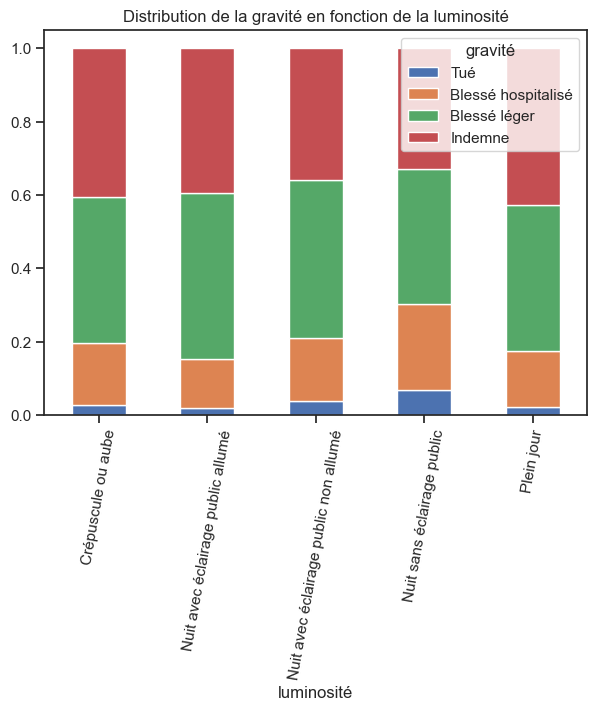

In [4]:
df_cross = pd.crosstab(df['luminosité'], df['gravité'], normalize='index')
df_cross = df_cross.reindex(columns=columns_titles)
print(df_cross)

sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(7, 5))
chart = df_cross.plot(kind="bar", stacked=True, rot=0, ax=ax, 
                         title='Distribution de la gravité en fonction de la luminosité')
chart.set_xticklabels(chart.get_xticklabels(), rotation=80)
sns.move_legend(ax, "upper right")


## Relation gravité - date

In [5]:
from bokeh.models import HoverTool
from bokeh.plotting import figure, output_notebook, show, ColumnDataSource
output_notebook()

df_cross = pd.crosstab(df['date'], df['gravité'], normalize='index')
df_cross = df_cross.reindex(columns=columns_titles)
df_cross.reset_index(inplace=True)
df_cross = df_cross.rename({'Tué':'tue', 'Blessé hospitalisé':'blesse_hosp', 'Blessé léger':'bless_leger', 'Indemne':'indemne'}, axis=1)
print(df_cross)

source = ColumnDataSource(df_cross) 

t1 = [("(date, y)", "(@date, @tue)")]
t2 = [("(date, y)", "(@date, @blesse_hosp)")]
t3 = [("(date, y)", "(@date, @bless_leger)")]
t4 = [("(date, y)", "(@date, @indemne)")]

p = figure(plot_width = 900, plot_height = 400, x_axis_type='datetime', title='Distribution quotidienne des accidents par gravité')

c1 = p.line(x = 'date', y = 'tue', source = source, color='red', legend_label='Tué')    
p.add_tools(HoverTool(renderers=[c1], tooltips=t1, mode='vline'))

c2 = p.line(x = 'date', y = 'blesse_hosp', source = source, color='orange', legend_label='Blessé hospitalisé')
p.add_tools(HoverTool(renderers=[c2], tooltips=t2, mode='vline'))

c3 = p.line(x = 'date', y = 'bless_leger', source = source, color='gray', legend_label='Blessé léger')
p.add_tools(HoverTool(renderers=[c3], tooltips=t3, mode='vline'))

c4 = p.line(x = 'date', y = 'indemne', source = source, color='green', legend_label='Indemne')
p.add_tools(HoverTool(renderers=[c4], tooltips=t4, mode='vline'))

p.legend.click_policy = 'hide'

show(p);


Loading BokehJS ...

gravité        date       tue  blesse_hosp  bless_leger   indemne
0        2020-01-01  0.043210     0.219136     0.441358  0.296296
1        2020-01-02  0.011538     0.096154     0.469231  0.423077
2        2020-01-03  0.039855     0.166667     0.398551  0.394928
3        2020-01-04  0.029091     0.145455     0.392727  0.432727
4        2020-01-05  0.042146     0.206897     0.402299  0.348659
..              ...       ...          ...          ...       ...
361      2020-12-27  0.037594     0.172932     0.421053  0.368421
362      2020-12-28  0.028986     0.126812     0.358696  0.485507
363      2020-12-29  0.011429     0.137143     0.474286  0.377143
364      2020-12-30  0.035714     0.142857     0.444444  0.376984
365      2020-12-31  0.008475     0.173729     0.453390  0.364407

[366 rows x 5 columns]


# Relation gravité - département


Top 10 des départements avec le taux de mortalité le plus élevé : 

gravité       Tué
dep              
987      0.114943
70       0.093137
40       0.086957
23       0.084507
61       0.080229
977      0.080000
89       0.077957
47       0.077882
02       0.075472
85       0.074653

Top 10 des départements avec le taux de mortalité le moins élevé : 

gravité       Tué
dep              
986      0.000000
975      0.000000
93       0.003559
94       0.004079
75       0.004683
05       0.005566
92       0.005578
69       0.007770
91       0.012420
78       0.015172


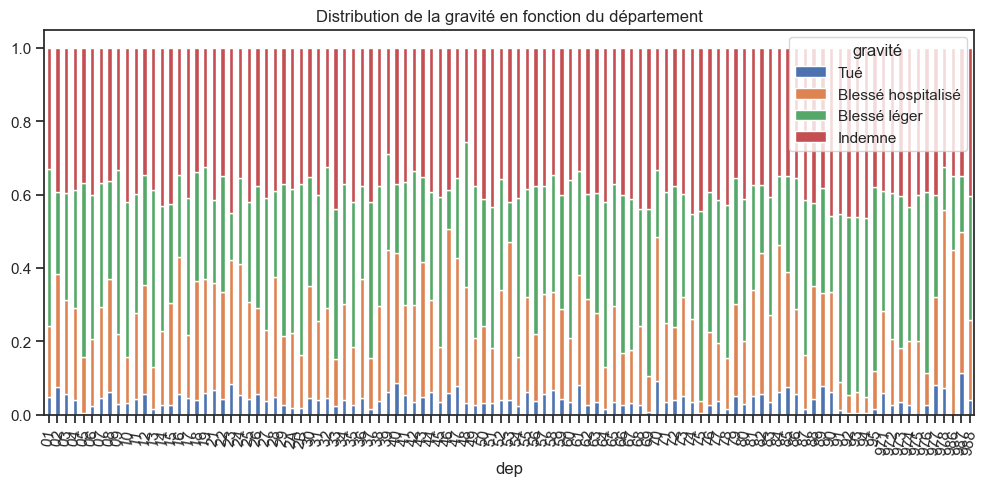

In [6]:
df_cross = pd.crosstab(df['dep'], df['gravité'], normalize='index')
df_cross = df_cross.reindex(columns=columns_titles)
# print(df_cross)

sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(12, 5))
chart = df_cross.plot(kind="bar", stacked=True, rot=0, ax=ax, 
                         title='Distribution de la gravité en fonction du département')
chart.set_xticklabels(chart.get_xticklabels(), rotation=80)
sns.move_legend(ax, "upper right")

tue_dep = df_cross[['Tué']]

stats_dep = tue_dep.sort_values(by='Tué', ascending=False)
print('\nTop 10 des départements avec le taux de mortalité le plus élevé : \n')
print(tue_dep[['Tué']].sort_values(by='Tué', ascending=False).head(10))

stats_dep = tue_dep.sort_values(by='Tué', ascending=False)
print('\nTop 10 des départements avec le taux de mortalité le moins élevé : \n')
print(tue_dep[['Tué']].sort_values(by='Tué', ascending=True).head(10))


## Relation gravité - localisation (agglo/hors agglo)

gravité                  Tué  Blessé hospitalisé  Blessé léger   Indemne
agg_lbl                                                                 
en agglomération    0.014317            0.123489      0.428721  0.433473
hors agglomération  0.046592            0.219165      0.361022  0.373221


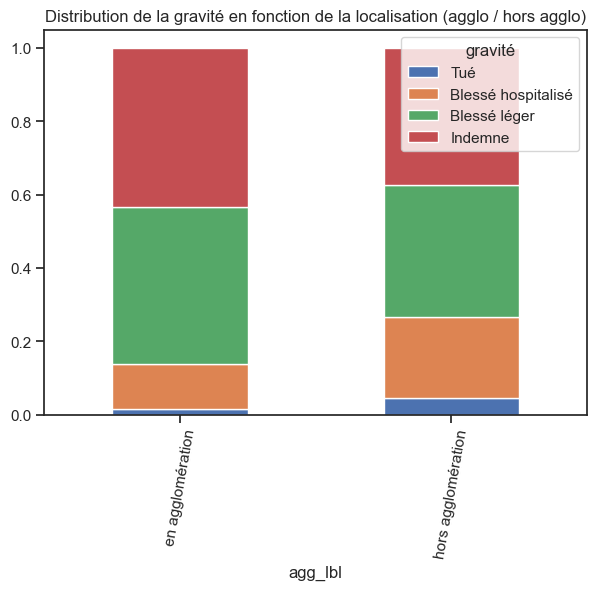

In [7]:
df_cross = pd.crosstab(df['agg_lbl'], df['gravité'], normalize='index')
df_cross = df_cross.reindex(columns=columns_titles)
print(df_cross)

sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(7, 5))
chart = df_cross.plot(kind="bar", stacked=True, rot=0, ax=ax, 
                         title='Distribution de la gravité en fonction de la localisation (agglo / hors agglo)')
chart.set_xticklabels(chart.get_xticklabels(), rotation=80)
sns.move_legend(ax, "upper right")

## Relation gravité - type d'intersection


gravité                                 Tué  Blessé hospitalisé  Blessé léger  \
int_lbl                                                                         
Autre intersection                 0.020116            0.149583      0.415579   
Giratoire                          0.016264            0.141296      0.406861   
Hors intersection                  0.033530            0.175276      0.397062   
Intersection en T                  0.012339            0.134567      0.406205   
Intersection en X                  0.010840            0.122954      0.420007   
Intersection en Y                  0.018337            0.141402      0.404238   
Intersection à plus de 4 branches  0.008535            0.093883      0.449502   
Passage à niveau                   0.091743            0.169725      0.311927   
Place                              0.007986            0.077196      0.472937   

gravité                             Indemne  
int_lbl                                      
Autre intersecti

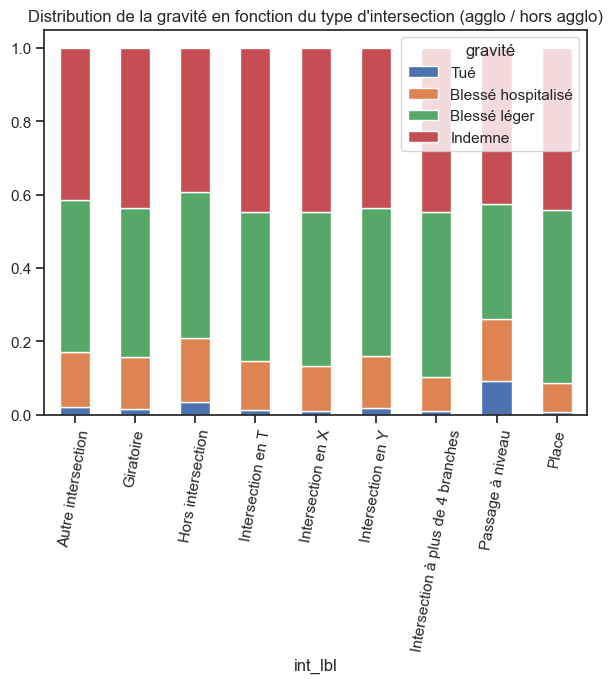

In [8]:
df_cross = pd.crosstab(df['int_lbl'], df['gravité'], normalize='index')
df_cross = df_cross.reindex(columns=columns_titles)
print(df_cross)

sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(7, 5))
chart = df_cross.plot(kind="bar", stacked=True, rot=0, ax=ax, 
                         title="Distribution de la gravité en fonction du type d'intersection (agglo / hors agglo)")
chart.set_xticklabels(chart.get_xticklabels(), rotation=80)
sns.move_legend(ax, "upper right")

## Relation gravité - conditions atmosphériques

gravité                   Tué  Blessé hospitalisé  Blessé léger   Indemne
atm_lbl                                                                  
Autre                0.042353            0.214118      0.369412  0.374118
Brouillard - fumée   0.059034            0.254025      0.363148  0.323792
Neige - grêle        0.011905            0.175595      0.342262  0.470238
Non renseigné        0.000000            0.000000      0.750000  0.250000
Normale              0.026179            0.160899      0.400867  0.412055
Pluie forte          0.031486            0.154912      0.411839  0.401763
Pluie légère         0.022074            0.131153      0.438250  0.408523
Temps couvert        0.031188            0.154208      0.407426  0.407178
Temps éblouissant    0.032326            0.226285      0.291468  0.449921
Vent fort - tempête  0.052083            0.273438      0.406250  0.268229


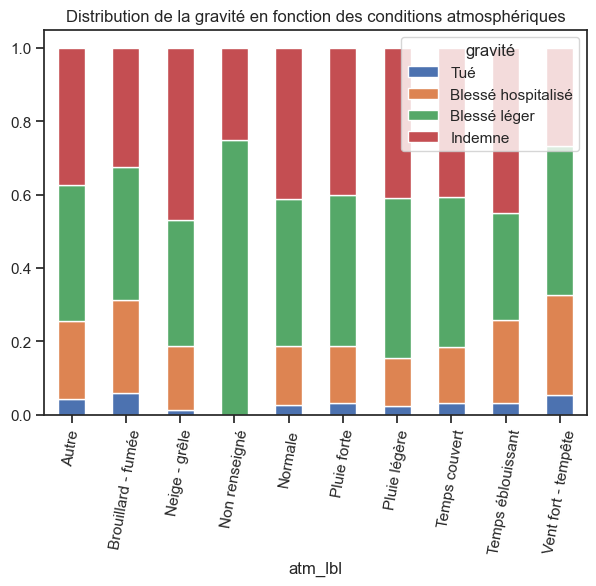

In [9]:
df_cross = pd.crosstab(df['atm_lbl'], df['gravité'], normalize='index')
df_cross = df_cross.reindex(columns=columns_titles)
print(df_cross)

sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(7, 5))
chart = df_cross.plot(kind="bar", stacked=True, rot=0, ax=ax, 
                         title="Distribution de la gravité en fonction des conditions atmosphériques")
chart.set_xticklabels(chart.get_xticklabels(), rotation=80)
sns.move_legend(ax, "upper right")

## Relation gravité - Type de collision

gravité                                              Tué  Blessé hospitalisé  \
col_lbl                                                                        
Autre collision                                 0.056831            0.224851   
Deux véhicules - frontale                       0.043146            0.230921   
Deux véhicules - par l'arrière                  0.011800            0.086461   
Deux véhicules - par le côté                    0.010745            0.120423   
Non renseigné                                   0.005941            0.133945   
Sans collision                                  0.032296            0.333727   
Trois véhicules et plus - collisions multiples  0.023363            0.102832   
Trois véhicules et plus - en chaîne             0.006750            0.042260   

gravité                                         Blessé léger   Indemne  
col_lbl                                                                 
Autre collision                                     0

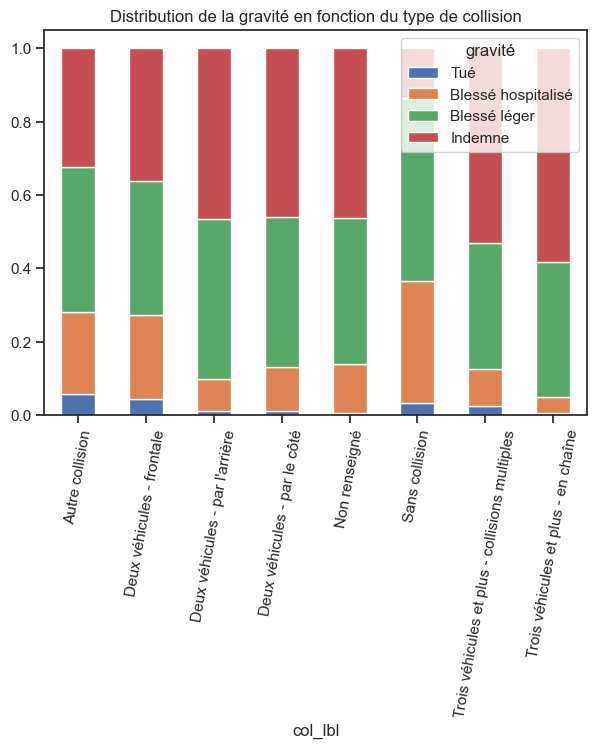

In [10]:
df_cross = pd.crosstab(df['col_lbl'], df['gravité'], normalize='index')
df_cross = df_cross.reindex(columns=columns_titles)
print(df_cross)

sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(7, 5))
chart = df_cross.plot(kind="bar", stacked=True, rot=0, ax=ax, 
                         title="Distribution de la gravité en fonction du type de collision")
chart.set_xticklabels(chart.get_xticklabels(), rotation=80)
sns.move_legend(ax, "upper right")